#### Limitations of image augmentation 
- Despite image augmentation We still don't have enough data for models suitable for something like ImageNet dataset
- Data collection is expensive
- Apply transfer learning - fine-tuning



### Steps to fine-tune
1. Pretrain a neural network model, i.e., the source model, on a source dataset (e.g., the ImageNet dataset).
2. Create a new neural network model, i.e., the target model. This copies all model designs and their parameters on the source model except the output layer.
3. Add an output layer to the target model, whose number of outputs is the number of categories in the target dataset. Then randomly initialize the model parameters of this layer.
4. Train the target model on the target dataset.

![](images/finetune.svg)


### Hot Dog Recognition

We will fine-tune a ResNet model on hot dog dataset to recognize hot dogs from images.

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### Reading the Dataset

In [2]:
# d2l.DATA_URL

In [3]:
# d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
#                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')

# data_dir = d2l.download_extract('hotdog')

In [4]:
data_dir = 'data/hotdog'

In [5]:
# training and testing datasets
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

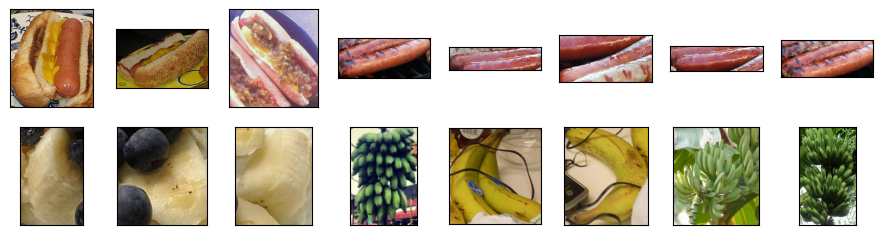

In [6]:
# first 8 positive examples and the last 8 negative images
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [7]:
# During training, we first crop a random area of random size and random aspect ratio from the image, and then scale this area to a 224 x 224 input image.

# During testing, we scale both the height and width of an image to 256 pixels, and then crop a central 224 x 224 area as input.

# Specify the means and standard deviations of the three RGB channels to
# standardize each channel

normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

### Defining and Initializing the Model

In [8]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


### Fine-Tuning the Model

In [9]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.204, train acc 0.924, test acc 0.920
123.4 examples/sec on [device(type='cuda', index=0)]


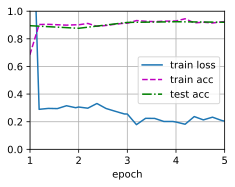

In [10]:
train_fine_tuning(finetune_net, 5e-5)

For comparison, we define an identical model, but initialize all of its model parameters to random values. Since the entire model needs to be trained from scratch, we can use a larger learning rate.

loss 0.358, train acc 0.849, test acc 0.848
122.6 examples/sec on [device(type='cuda', index=0)]


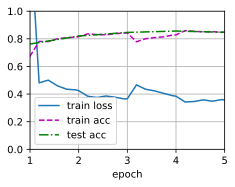

In [11]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

As we can see, the fine-tuned model tends to perform better for the same epoch because its initial parameter values are more effective.

### One Prediction for hot dog

In [12]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [13]:
# Load 
hotdog_image_path = 'data/hotdog/test/hotdog/1000.png'
not_hotdog_image_path = 'data/hotdog/test/not-hotdog/1000.png'

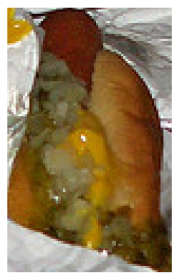

In [14]:
# Open the image using PIL
image = Image.open(hotdog_image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

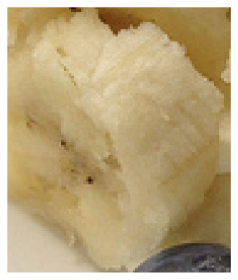

In [15]:
# Open the image using PIL
image = Image.open(not_hotdog_image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

#### Inference for hot dog

In [16]:
# preprocess the single image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the desired input size
    transforms.ToTensor(),           # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
image = Image.open(hotdog_image_path)
image = transform(image)

In [17]:
# Ensure the image is in a batch-like shape (batch size of 1)
image = image.unsqueeze(0)  # Add a batch dimension

In [18]:
# Move the image to the appropriate device (e.g., GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image = image.to(device)

In [19]:
# Perform the forward pass to get predictions
finetune_net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = finetune_net(image)
    print(predictions)

tensor([[-0.2516, -0.7124]], device='cuda:0')


In [20]:
# Apply softmax to convert to probabilities
probabilities = F.softmax(predictions, dim=1)
print(probabilities)

tensor([[0.6132, 0.3868]], device='cuda:0')


#### Inference for not hot dog

In [21]:
# preprocess the single image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the desired input size
    transforms.ToTensor(),           # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
image = Image.open(not_hotdog_image_path)
image = transform(image)

In [22]:
# Ensure the image is in a batch-like shape (batch size of 1)
image = image.unsqueeze(0)  # Add a batch dimension

In [23]:
# Move the image to the appropriate device (e.g., GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image = image.to(device)

In [24]:
# Perform the forward pass to get predictions
finetune_net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = finetune_net(image)
    print(predictions)

tensor([[0.0167, 1.1870]], device='cuda:0')


In [25]:
# Apply softmax to convert to probabilities
probabilities = F.softmax(predictions, dim=1)
print(probabilities)

tensor([[0.2368, 0.7632]], device='cuda:0')
